In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torchvision.utils import save_image
import os

In [20]:
# Check CUDA availability
use_cuda = torch.cuda.is_available()

# Set device
device = torch.device("cuda" if use_cuda else "cpu")

In [21]:
# Define a custom dataset class
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_files[index])
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image

In [22]:
# Set the path to the directory containing the images
data_dir = 'D:\Development\DeepLearning\data\lung_colon_image_set\lung_image_sets\lung_scc'

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the custom dataset
dataset = ImageDataset(data_dir, transform=transform)

# Create a data loader
batch_size = 128
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [23]:
# Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim_g, img_shape_g):
        super(Generator, self).__init__()
        self.img_shape_g = img_shape_g

        self.model = nn.Sequential(
            nn.Linear(latent_dim_g, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(np.prod(img_shape_g))),
            nn.Tanh()
        )

    def forward(self, z_g):
        img = self.model(z_g)
        img = img.view(img.size(0), *self.img_shape_g)
        return img

In [24]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, img_shape_g):
        super(Discriminator, self).__init__()
        self.img_shape_g = img_shape_g

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [25]:
# Define the input shape and latent dimension
img_shape = (3, 64, 64)
latent_dim = 50

# Create the generator and discriminator
generator = Generator(latent_dim, img_shape).to(device)
discriminator = Discriminator(img_shape).to(device)

# Loss function
adversarial_loss = nn.BCELoss().to(device)

In [26]:
# Loss function
# adversarial_loss = nn.BCELoss()

# Optimizers
lr = 0.0001
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [27]:
num_epochs = 40
sample_interval = 50
generated_count = 0

# Create the directory to save generated images
os.makedirs("lung_image_sets/lung_scc", exist_ok=True)

for epoch in range(num_epochs):
    for i, imgs in enumerate(data_loader):
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Move real images to device
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Generate a batch of fake images from random noise
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_imgs = generator(z)

        # Compute the discriminator loss for real and fake images
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation and optimization
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate a batch of fake images from random noise
        gen_imgs = generator(z)

        # Compute the generator loss
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        # Backpropagation and optimization
        g_loss.backward()
        optimizer_G.step()

        # Print training progress
        batches_done = epoch * len(data_loader) + i
        if batches_done % sample_interval == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(data_loader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

        # Save generated images
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], f"lung_image_sets/lung_scc/{batches_done}.png", nrow=5, normalize=True)

[Epoch 0/40] [Batch 0/40] [D loss: 0.7005] [G loss: 0.7505]
[Epoch 1/40] [Batch 10/40] [D loss: 0.3398] [G loss: 1.6486]
[Epoch 2/40] [Batch 20/40] [D loss: 0.2418] [G loss: 2.4145]
[Epoch 3/40] [Batch 30/40] [D loss: 0.5059] [G loss: 1.1445]
[Epoch 5/40] [Batch 0/40] [D loss: 0.5111] [G loss: 2.2798]
[Epoch 6/40] [Batch 10/40] [D loss: 0.5628] [G loss: 2.6921]
[Epoch 7/40] [Batch 20/40] [D loss: 0.6081] [G loss: 0.7107]
[Epoch 8/40] [Batch 30/40] [D loss: 0.6031] [G loss: 1.6002]
[Epoch 10/40] [Batch 0/40] [D loss: 0.7436] [G loss: 0.3569]
[Epoch 11/40] [Batch 10/40] [D loss: 0.6660] [G loss: 1.5797]
[Epoch 12/40] [Batch 20/40] [D loss: 0.6970] [G loss: 0.9695]
[Epoch 13/40] [Batch 30/40] [D loss: 0.7010] [G loss: 0.5493]
[Epoch 15/40] [Batch 0/40] [D loss: 0.5871] [G loss: 1.1485]
[Epoch 16/40] [Batch 10/40] [D loss: 0.6533] [G loss: 1.7125]
[Epoch 17/40] [Batch 20/40] [D loss: 0.5887] [G loss: 1.5827]
[Epoch 18/40] [Batch 30/40] [D loss: 0.5860] [G loss: 1.1992]
[Epoch 20/40] [Batch

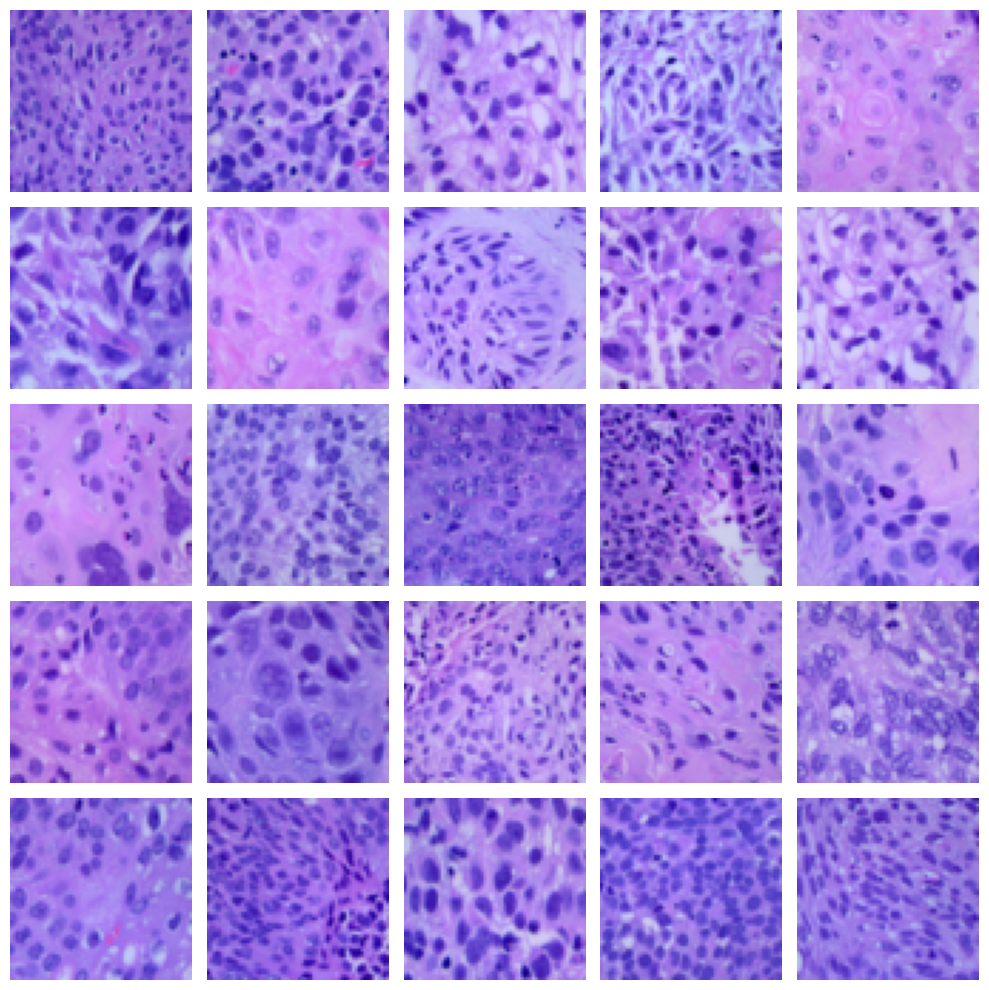

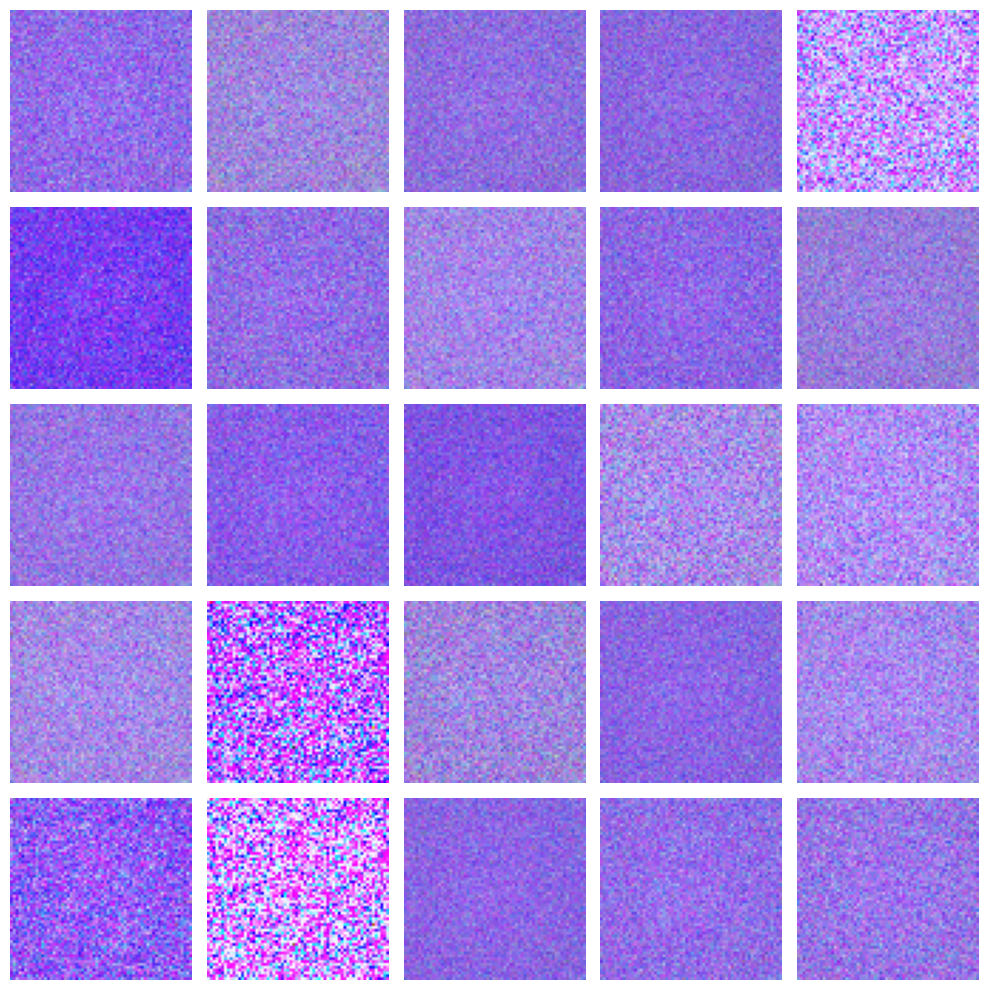

In [28]:
import matplotlib.pyplot as plt

# Define a function to plot images
def plot_images(images):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        img = img.cpu().numpy().transpose(1, 2, 0)  # Transpose image tensor
        img = (img + 1) / 2  # Denormalize image
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generate random noise for plotting
z = torch.randn(25, latent_dim).to(device)
gen_imgs = generator(z).detach()

# Randomly select original images
num_original_images = 25
original_indices = torch.randint(len(dataset), (num_original_images,))
original_imgs = torch.stack([dataset[i] for i in original_indices])

# Plot original and generated images
plot_images(original_imgs)
plot_images(gen_imgs)